<a href="https://colab.research.google.com/github/kkhhmm3103/SSU_Datathon2025/blob/main/AI%E1%84%8F%E1%85%B5%E1%84%8B%E1%85%AF%E1%84%83%E1%85%B3%E1%84%89%E1%85%A2%E1%86%BC%E1%84%89%E1%85%A5%E1%86%BC_%E1%84%8C%E1%85%A6%E1%84%8E%E1%85%AE%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
# 입력/설정
IN_PATH = "keyword_bert_df.csv"
PREFERRED_KW_COLS = ["KYWD_NORM", "KW_LIST_NORM", "KW_LIST_RAW", "KYWD"]
SEP = ","

TOP_KW_PER_DOC = 12     # 한 문서 키워드 너무 많을 때 폭발 방지
MIN_EDGE_W = 4          # 공출현 엣지 최소 가중치 (3~10 조정)

BUNDLE_MODE = "top_n"   # "top_n" | "threshold" | "k_hop"

TOP_N = 200             # mode=top_n일 때: AI 묶음에 포함할 키워드 수
PPR_THRESHOLD = 1e-5    # mode=threshold일 때: ppr 점수 임계값
K_HOP = 2               # mode=k_hop일 때: 시드로부터 k-hop 이내만 고려
K_HOP_MIN_PPR = 1e-6    # mode=k_hop일 때: k-hop 이내에서도 너무 약한 건 제외

# seed 리스트
AI_SEEDS = [
    "affective computing", "reinforcement learning", "large language model",
    "large action model", "retrieval augmented generation",
    "small language model", "high bandwidth memory", "spatial intelligence",
    "overfitting", "optical character recognition",
    "graphics processing unit", "symbolic artificial intelligence",
    "neuromorphic computing", "conversational artificial intelligence",
    "data labeling", "data wrangling", "data silo", "data preprocessing",
    "data flywheel", "deep learning", "deepfake", "low code", "parameter",
    "machine learning", "machine learning operations", "multimodal learning",
    "processing in memory", "metadata", "meta learning", "model compression",
    "model context protocol", "fine tuning", "vibe coding",
    "vertical artificial intelligence", "benchmark dataset",
    "distributed training", "vision language model", "chain of thought",
    "pretrained model", "generative adversarial network",
    "generative artificial intelligence", "shadow artificial intelligence",
    "artificial intelligence as a service", "explainable artificial intelligence",
    "recurrent neural network", "simulation to real transfer",
    "autoencoder", "open source artificial intelligence",
    "on device artificial intelligence", "world model", "anomaly detection",
    "causal artificial intelligence", "embedding", "automated machine learning",
    "natural language processing", "low rank adaptation", "accuracy",
    "zero shot learning", "intelligent radio access network powered by artificial intelligence",
    "artificial intelligence of things", "supervised learning", "knowledge distillation",
    "curse of dimensionality", "test time compute", "jailbreak", "token",
    "turing test", "transformer architecture", "foundation model",
    "discriminative artificial intelligence", "fabless semiconductor company",
    "frontier artificial intelligence", "prompt", "prompt injection",
    "physical artificial intelligence", "fin field effect transistor",
    "convolutional neural network", "synthetic data", "hallucination",
    "artificial intelligence guardrails", "artificial intelligence accelerator",
    "artificial intelligence divide", "artificial intelligence native",
    "artificial intelligence data center", "artificial intelligence red teaming",
    "artificial intelligence literacy", "artificial intelligence semiconductor",
    "artificial intelligence reliability", "artificial intelligence safety",
    "artificial intelligence assistant", "artificial intelligence agent",
    "artificial intelligence orchestration", "artificial intelligence watermarking",
    "artificial intelligence ethics", "artificial intelligence transformation",
    "artificial intelligence alignment", "artificial intelligence reasoning",
    "artificial intelligence inference", "artificial intelligence bias",
    "artificial intelligence virtual human"
]

def norm_kw(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("–", "-").replace("—", "-")
    return s

AI_SEEDS = [norm_kw(x) for x in AI_SEEDS]

# 데이터 로드 + 키워드 컬럼 선택
df = pd.read_csv(IN_PATH, encoding="utf-8-sig")

kw_col = None
for c in PREFERRED_KW_COLS:
    if c in df.columns:
        kw_col = c
        break
if kw_col is None:
    raise ValueError(f"키워드 컬럼을 못 찾음. 현재 컬럼: {list(df.columns)}")

print("using keyword column:", kw_col)

def split_kw_cell(x):
    if not isinstance(x, str) or not x.strip():
        return []
    kws = [norm_kw(k) for k in x.split(SEP) if k.strip()]
    # 중복 제거
    seen = set()
    out = []
    for k in kws:
        if k and k not in seen:
            seen.add(k)
            out.append(k)
    return out[:TOP_KW_PER_DOC]

docs = df[kw_col].apply(split_kw_cell).tolist()

# 공출현 그래프 만들기
edge_counter = Counter()
node_counter = Counter()

for kws in docs:
    for k in kws:
        node_counter[k] += 1
    for a, b in combinations(sorted(set(kws)), 2):
        edge_counter[(a, b)] += 1

G = nx.Graph()
for k, f in node_counter.items():
    G.add_node(k, frequency=f)

for (a, b), w in edge_counter.items():
    if w >= MIN_EDGE_W:
        G.add_edge(a, b, weight=w)

print("graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# 데이터 안에 실제 존재하는 seed(앵커)만 사용
seed_set = set(AI_SEEDS)
anchors = [n for n in G.nodes if n in seed_set]

# seed 표기 차이 흡수
if len(anchors) < 5:
    def soft_match(node):
        for s in AI_SEEDS:
            if len(s) >= 18 and (s in node or node in s):
                return True
        return False
    anchors = sorted({n for n in G.nodes if (n in seed_set) or soft_match(n)})

print("anchors found:", len(anchors))
print("sample anchors:", anchors[:25])

if len(anchors) < 2:
    raise RuntimeError(
        "데이터에서 seed가 거의 매칭되지 않음"
    )

# Personalized PageRank: 시드 중심 AI 연관도 계산
personalization = {n: 0.0 for n in G.nodes}
for a in anchors:
    personalization[a] = 1.0
s = sum(personalization.values())
personalization = {k: v/s for k, v in personalization.items()}

ppr = nx.pagerank(G, alpha=0.85, personalization=personalization, weight="weight")

rank_df = (
    pd.DataFrame({
        "keyword": list(ppr.keys()),
        "ai_relatedness_ppr": list(ppr.values()),
        "frequency": [G.nodes[k].get("frequency", 0) for k in ppr.keys()],
        "is_seed": [k in set(anchors) for k in ppr.keys()],
    })
    .sort_values(["ai_relatedness_ppr", "frequency"], ascending=False)
    .reset_index(drop=True)
)

# 하나의 AI 묶음 만들기 (군집화 X)
if BUNDLE_MODE == "top_n":
    ai_bundle = set(rank_df.head(TOP_N)["keyword"].tolist())

elif BUNDLE_MODE == "threshold":
    ai_bundle = set(rank_df[rank_df["ai_relatedness_ppr"] >= PPR_THRESHOLD]["keyword"].tolist())

elif BUNDLE_MODE == "k_hop":
    # seed에서 k-hop 이내 노드들만 후보로 삼고, 그 중 ppr도 어느정도 이상만
    k_hop_nodes = set()
    for a in anchors:
        lengths = nx.single_source_shortest_path_length(G, a, cutoff=K_HOP)
        k_hop_nodes.update(lengths.keys())
    tmp = rank_df[rank_df["keyword"].isin(k_hop_nodes)].copy()
    tmp = tmp[tmp["ai_relatedness_ppr"] >= K_HOP_MIN_PPR]
    ai_bundle = set(tmp["keyword"].tolist())

else:
    raise ValueError("BUNDLE_MODE는 'top_n' | 'threshold' | 'k_hop' 중 하나여야 함.")

# seed는 무조건 포함
ai_bundle.update(anchors)

# seed와 연결된 컴포넌트만 남기기
#    -> ai_bundle 안에 잡음이 섞여도 seed와 실제로 연결된 것만 남음
H = G.subgraph(ai_bundle).copy()

# seed가 속한 연결요소(컴포넌트)만 유지
seed_component_nodes = set()
for comp in nx.connected_components(H):
    if any(n in comp for n in anchors):
        seed_component_nodes.update(comp)

H = H.subgraph(seed_component_nodes).copy()

# 최종 bundle
final_bundle = list(H.nodes())
final_bundle_df = rank_df[rank_df["keyword"].isin(final_bundle)].copy()
final_bundle_df = final_bundle_df.sort_values(["ai_relatedness_ppr","frequency"], ascending=False)

# 단일 묶음 결과
final_bundle_df.to_csv("ai_bundle_keywords.csv", index=False, encoding="utf-8-sig")

# 묶음의 엣지 저장
edge_rows = []
for u, v, d in H.edges(data=True):
    edge_rows.append({"source": u, "target": v, "weight": d.get("weight", 1)})
pd.DataFrame(edge_rows).to_csv("ai_bundle_edges.csv", index=False, encoding="utf-8-sig")

print(" saved:")
print("- ai_bundle_keywords.csv  (시드 중심 '단일 AI 묶음' 키워드 목록)")
print("- ai_bundle_edges.csv     (그 묶음 내부 공출현 엣지)")

print("\n[final bundle size]", len(final_bundle))
print("[top 30]")
print(final_bundle_df.head(30)[["keyword","ai_relatedness_ppr","frequency","is_seed"]].to_string(index=False))

using keyword column: KYWD_NORM
graph nodes: 154768 edges: 3907
anchors found: 55
sample anchors: ['deep learning', 'convolutional neural network', 'reinforcement learning', 'machine learning', 'generative adversarial network', 'anomaly detection', 'natural language processing', 'autoencoder', 'supervised learning', 'recurrent neural network', 'synthetic data', 'knowledge distillation', 'model compression', 'embedding', 'optical character recognition', 'accuracy', 'parameter', 'overfitting', 'fine tuning', 'metadata', 'affective computing', 'deepfake', 'explainable artificial intelligence', 'prompt', 'multimodal learning']
 saved:
- ai_bundle_keywords.csv  (시드 중심 '단일 AI 묶음' 키워드 목록)
- ai_bundle_edges.csv     (그 묶음 내부 공출현 엣지)

[final bundle size] 200
[top 30]
                            keyword  ai_relatedness_ppr  frequency  is_seed
                      deep learning            0.118322       2035     True
            artificial intelligence            0.035462        908    False
    

전기전자공학      5468
컴퓨터학        2752
기계공학        1684
공학 일반       1233
건축공학         797
산업공학         495
기타 공학        253
재료·에너지공학     118
조선해양공학       108
화학공학          19
Name: NODE_CLSS_02, dtype: int64


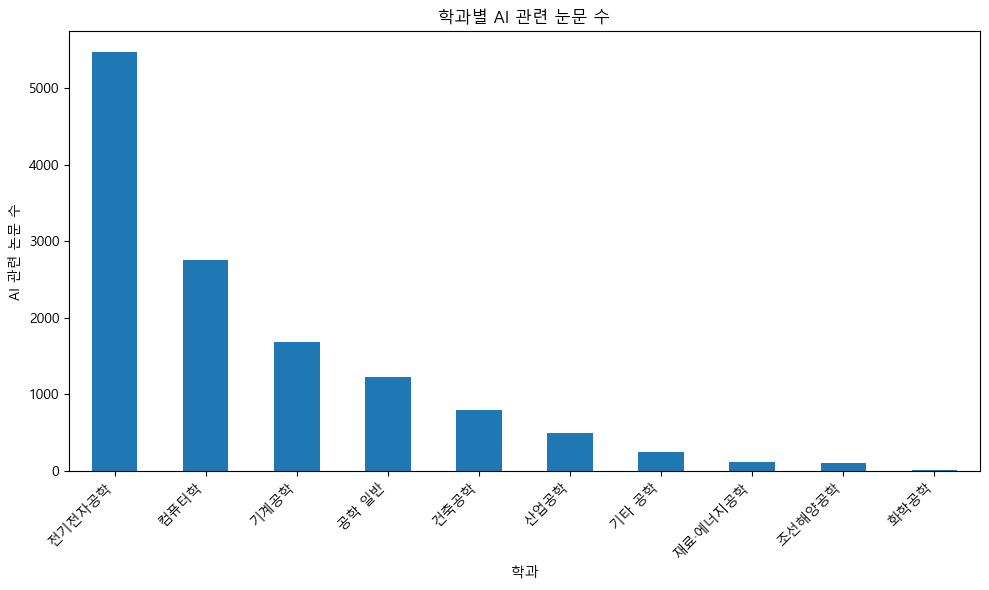

In [ ]:
# 깨짐방지
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

DATA_PATH = "dataset_ai_only.csv"   # AI 필터링된 데이터셋
DEPT_COL = "NODE_CLSS_02"            # 학과/분야 컬럼 (필요시 NODE_CLSS_02로 변경)

df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")

# 학과별 데이터 수 집계
dept_counts = (
    df[DEPT_COL]
    .dropna()
    .value_counts()
    .sort_values(ascending=False)
)

print(dept_counts)

# 바차트 시각화
plt.figure(figsize=(10, 6))
dept_counts.plot(kind="bar")
plt.xlabel("학과")
plt.ylabel("AI 관련 논문 수")
plt.title("학과별 AI 관련 눈문 수")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

          전체_데이터_수  AI_데이터_수     AI_비율
컴퓨터학          5590      2752  0.492308
산업공학          1273       495  0.388845
전기전자공학       15265      5468  0.358205
공학 일반         5530      1233  0.222966
기타 공학         1289       253  0.196276
기계공학          8915      1684  0.188895
조선해양공학         604       108  0.178808
건축공학          6751       797  0.118057
재료·에너지공학      1069       118  0.110384
화학공학           824        19  0.023058


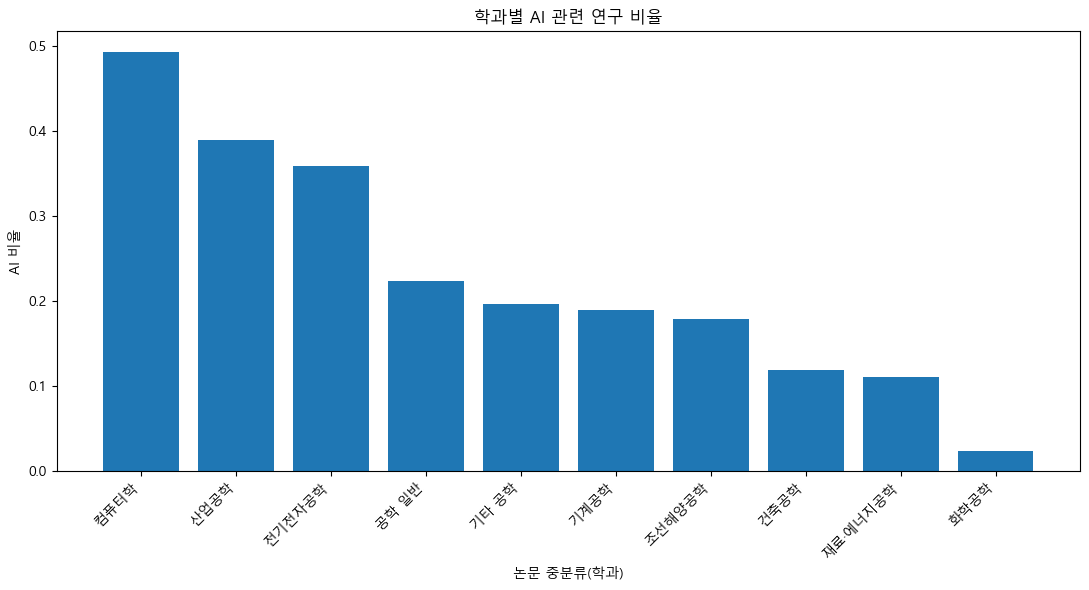

In [ ]:
ALL_PATH = "keyword_bert_df.csv"   # 전체 데이터
AI_PATH  = "ai_only_df.csv"              # AI 필터링 데이터

CLASS_COL = "NODE_CLSS_02"   # 학문 중분류

df_all = pd.read_csv(ALL_PATH, encoding="utf-8-sig")
df_ai  = pd.read_csv(AI_PATH, encoding="utf-8-sig")

# 중분류별 데이터 수 집계
all_counts = (
    df_all[CLASS_COL]
    .dropna()
    .value_counts()
)

ai_counts = (
    df_ai[CLASS_COL]
    .dropna()
    .value_counts()
)

# 비율 계산
ratio_df = pd.DataFrame({
    "전체_데이터_수": all_counts,
    "AI_데이터_수": ai_counts
}).fillna(0)

ratio_df["AI_비율"] = ratio_df["AI_데이터_수"] / ratio_df["전체_데이터_수"]

ratio_df = ratio_df.sort_values("AI_비율", ascending=False)

print(ratio_df)

# 바차트 시각화
plt.figure(figsize=(11, 6))
plt.bar(ratio_df.index, ratio_df["AI_비율"])
plt.ylabel("AI 비율")
plt.xlabel("논문 중분류(학과)")
plt.title("학과별 AI 관련 연구 비율")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

          AI 연구  비AI 연구
전기전자공학     5468    9797
컴퓨터학       2752    2838
기계공학       1684    7231
공학 일반      1233    4297
건축공학        797    5954
산업공학        495     778
기타 공학       253    1036
재료·에너지공학    118     951
조선해양공학      108     496
화학공학         19     805


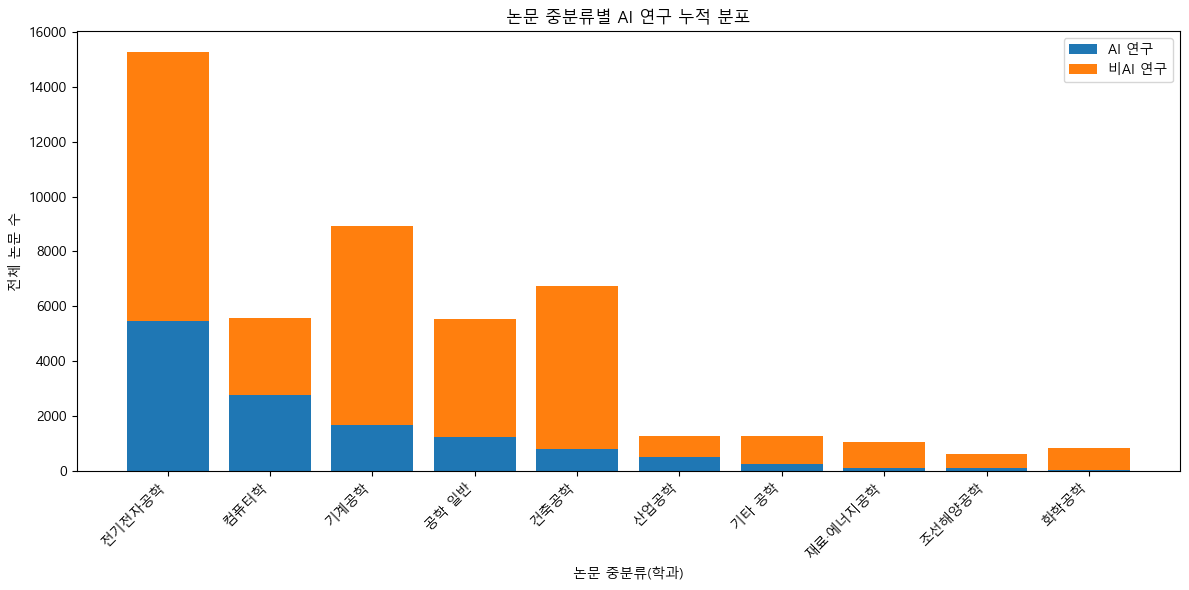

In [ ]:
df_all = pd.read_csv(ALL_PATH, encoding="utf-8-sig")
df_ai  = pd.read_csv(AI_PATH, encoding="utf-8-sig")

# 중분류별 데이터 수 집계
all_counts = (
    df_all[CLASS_COL]
    .dropna()
    .value_counts()
)

ai_counts = (
    df_ai[CLASS_COL]
    .dropna()
    .value_counts()
)

# 누적 바그래프용 데이터 구성
plot_df = pd.DataFrame({
    "AI 연구": ai_counts,
    "비AI 연구": all_counts - ai_counts
}).fillna(0)

plot_df = plot_df.sort_values("AI 연구", ascending=False)

print(plot_df)

# 누적 바그래프 시각화
plt.figure(figsize=(12, 6))

plt.bar(plot_df.index, plot_df["AI 연구"], label="AI 연구")
plt.bar(
    plot_df.index,
    plot_df["비AI 연구"],
    bottom=plot_df["AI 연구"],
    label="비AI 연구"
)

plt.ylabel("전체 논문 수")
plt.xlabel("논문 중분류(학과)")
plt.title("논문 중분류별 AI 연구 누적 분포")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()